### Libraries and data loading

In [ ]:
# import libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import datetime
import itertools
import h5py
import matplotlib.dates as mdates

%matplotlib inline

In [ ]:
# check tensorflow version
print("tensorflow version:", tf.__version__)
# check available gpu
gpus =  tf.config.list_physical_devices('GPU')
print("available gpus:", gpus)
# limit the gpu usage, prevent it from allocating all gpu memory for a simple model
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
# check number of cpus available
print("available cpus:", os.cpu_count())

tensorflow version: 2.19.0
available gpus: []
available cpus: 2


In [ ]:
# define the data location and load data

from google.colab import drive
drive.mount('/content/drive')

data_folder = "/content/drive/MyDrive/Solar_Project/Stanford-solar-forecasting-dataset"
data_path = os.path.join(data_folder, "2017_2019_images_pv_processed.hdf5")

# !change model name for different models!
model_name = 'SUNSET_nowcast_2017_2019_data'
output_folder = os.path.join(data_folder,"models", model_name)
if os.path.isdir(output_folder)==False:
    os.makedirs(output_folder)

print("data_folder:", data_folder)
print("data_path:", data_path)
print("output_folder:", output_folder)

Mounted at /content/drive
data_folder: /content/drive/MyDrive/Solar_Project/Stanford-solar-forecasting-dataset
data_path: /content/drive/MyDrive/Solar_Project/Stanford-solar-forecasting-dataset/2017_2019_images_pv_processed.hdf5
output_folder: /content/drive/MyDrive/Solar_Project/Stanford-solar-forecasting-dataset/models/SUNSET_nowcast_2017_2019_data


In [ ]:
# generate handler for the hdf5 data
forecast_dataset = h5py.File(data_path, 'r')

# show structure of the hdf5 data
def get_all(name):
    if name!=None:
        print(forecast_dataset[name])

forecast_dataset.visit(get_all)

<HDF5 group "/test" (2 members)>
<HDF5 dataset "images_log": shape (14003, 64, 64, 3), type "|u1">
<HDF5 dataset "pv_log": shape (14003,), type "<f8">
<HDF5 group "/trainval" (2 members)>
<HDF5 dataset "images_log": shape (349372, 64, 64, 3), type "|u1">
<HDF5 dataset "pv_log": shape (349372,), type "<f8">


In [ ]:
print('-'*50)
# get the input dimension for constructing the model
img_side_len = forecast_dataset['trainval']['images_log'].shape[1]
num_color_channel = forecast_dataset['trainval']['images_log'].shape[3]
image_input_dim = [img_side_len,img_side_len,num_color_channel]

print("image side length:", img_side_len)
print("number of color channels:", num_color_channel)
print("input image dimension:", image_input_dim)

# load time stamps into the memory
times_trainval = np.load(os.path.join(data_folder,"times_trainval.npy"),allow_pickle=True)
print("times_trainval.shape:", times_trainval.shape)

# read through the dataset once in order to cache it but not store it into the memory
## read the data by batch
num_samples = len(times_trainval)
batch_size = num_samples//5
indices = np.arange(num_samples)
print('-'*50)
print('data reading start...')
for i in range(int(num_samples / batch_size) + 1):
    start_time = time.time()
    start_idx = (i * batch_size) % num_samples
    idxs = indices[start_idx:start_idx + batch_size]
    _ = forecast_dataset['trainval']['images_log'][idxs]
    _ = forecast_dataset['trainval']['pv_log'][idxs]
    end_time = time.time()
    print("batch {0} samples: {1} to {2}, {3:.2f}% finished, processing time {4:.2f}s"
          .format(i+1, idxs[0],idxs[-1],(idxs[-1]/num_samples)*100,(end_time-start_time)))

# temporially close the dataset, will use "with" statement to open it when we use it
forecast_dataset.close()

--------------------------------------------------
image side length: 64
number of color channels: 3
input image dimension: [64, 64, 3]
times_trainval.shape: (349372,)
--------------------------------------------------
data reading start...
batch 1 samples: 0 to 69873, 20.00% finished, processing time 10.04s
batch 2 samples: 69874 to 139747, 40.00% finished, processing time 9.70s
batch 3 samples: 139748 to 209621, 60.00% finished, processing time 11.77s
batch 4 samples: 209622 to 279495, 80.00% finished, processing time 13.14s
batch 5 samples: 279496 to 349369, 100.00% finished, processing time 10.51s
batch 6 samples: 349370 to 349371, 100.00% finished, processing time 0.00s


### Input data pipeline helper functions

In [ ]:
# day block shuffling of the time stamps, and return shuffled indices
def day_block_shuffle(times_trainval):

    # Only keep the date of each time point
    dates_trainval = np.zeros_like(times_trainval, dtype=datetime.date)
    for i in range(len(times_trainval)):
        dates_trainval[i] = times_trainval[i].date()

    # Chop the indices into blocks, so that each block contains the indices of the same day
    unique_dates = np.unique(dates_trainval)
    blocks = []
    for i in range(len(unique_dates)):
        blocks.append(np.where(dates_trainval == unique_dates[i])[0])

    # shuffle the blocks, and chain it back together
    np.random.seed(1)
    np.random.shuffle(blocks)
    shuffled_indices = np.asarray(list(itertools.chain.from_iterable(blocks)))

    return shuffled_indices

In [ ]:
# a cross validation generator function for spliting the dayblock shuffled indices into training and validation
def cv_split(split_data, fold_index, num_fold):
    '''
    input:
    split_data: the dayblock shuffled indices to be splitted
    fold_index: the ith fold chosen as the validation, used for generating the seed for random shuffling
    num_fold: N-fold cross validation
    output:
    data_train: the train data indices
    data_val: the validation data indices
    '''
    # randomly divides into a training set and a validation set
    num_samples = len(split_data)
    indices = np.arange(num_samples)

    # finding training and validation indices
    val_mask = np.zeros(len(indices), dtype=bool)
    val_mask[int(fold_index / num_fold * num_samples):int((fold_index + 1) / num_fold * num_samples)] = True
    val_indices = indices[val_mask]
    train_indices = indices[np.logical_not(val_mask)]

    # shuffle indices
    np.random.seed(fold_index)
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

    data_train = split_data[train_indices]
    data_val = split_data[val_indices]

    return data_train,data_val

In [ ]:
# a mapping function from the indices to the corresponding features and labels
def data_loader(hdf5_data_path,sample_idx,batch_size=256):
    '''
    input:
    hdf5_data_path: path to hdf5 data file
    sample_idx:
        for training and validation:
            dayblock shuffled indices with cross-validation split into training and validation
            either training or validation indices will be input
        for testing: the indices are not shuffled
    is_trainval: a flag, True for trainig and validation
    output:
    dataset: dataset for training, validation
    '''

    def mapping_func_py(hdf5_data_path,sample_idx):
        '''
        mapping indices to corresponding images and pviance data in hdf5 (python expression)
        '''
        # convert EagerTensor to str or numpy array
        hdf5_data_path = hdf5_data_path.numpy().decode()
        # sort the sample indices as hdf5 requires increasing order index for data retrieval
        sample_idx = sorted(sample_idx.numpy())

        with h5py.File(hdf5_data_path,'r') as f:

            # read in the data
            images_log = f['trainval']['images_log'][sample_idx]
            pv_log = f['trainval']['pv_log'][sample_idx]

            # normalize image data to [0,1]
            images_log = tf.image.convert_image_dtype(images_log, tf.float32)

            # convert pv data to tf.tensor
            pv_log = tf.convert_to_tensor(pv_log, dtype=tf.float32)

            return images_log, pv_log

    def mapping_func_tf(hdf5_data_path,sample_idx):
        '''
        a wrapper mapping function to get the nested data structure
        the output type of tf.py_function cannot be a nested sequence when using a tf.py_function with the tf.data API
        '''
        images_log, pv_log = tf.py_function(func=mapping_func_py,
                                                           inp=[hdf5_data_path, sample_idx],
                                                           Tout=(tf.float32, tf.float32))

        images_log.set_shape([None, 64, 64, 3])
        pv_log.set_shape([None])

        return images_log, pv_log


    # create the indices dataset
    idx_ds = tf.data.Dataset.from_tensor_slices(sample_idx)
    # shuffle and batch the indices
    idx_ds = idx_ds.shuffle(buffer_size = idx_ds.cardinality().numpy(),seed=0)
    idx_ds = idx_ds.batch(batch_size).repeat().prefetch(tf.data.experimental.AUTOTUNE)

    # indices dataset mapping to images and pviance data
    # returning dataset with the following nested structure: (images_log, pv_log), pv_pred
    dataset = idx_ds.map(lambda x: mapping_func_tf(hdf5_data_path,x),
                         num_parallel_calls=tf.data.experimental.AUTOTUNE)

    return dataset

### Model architecture

In [ ]:
# define model characteristics
num_filters = 24
kernel_size = [3,3]
pool_size = [2,2]
strides = 2
dense_size = 1024
drop_rate = 0.4

# define training time parameters
num_epochs = 200 #(The maximum epoches set to 200 and there might be early stopping depends on validation loss)
num_fold = 10 # 10-fold cross-validation
batch_size = 256
learning_rate = 3e-06

In [ ]:
# define the model architecture using tf.keras API
def sunset_model():
    ## input
    ### input image logs with shape (64,64,24)
    x_in = keras.Input(shape=image_input_dim)

    ## 1st convolution block
    x = keras.layers.Conv2D(num_filters,kernel_size,padding="same",activation='relu')(x_in)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D(pool_size, strides)(x)

    ## 2nd convolution block
    x = keras.layers.Conv2D(num_filters*2,kernel_size,padding="same",activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D(pool_size, strides)(x)

    ## two fully connected nets
    x = keras.layers.Flatten()(x)

    x = keras.layers.Dense(dense_size, activation='relu')(x)
    x = keras.layers.Dropout(drop_rate)(x)
    x = keras.layers.Dense(dense_size, activation='relu')(x)
    x = keras.layers.Dropout(drop_rate)(x)

    ## regression to prediction target
    y_out = keras.layers.Dense(units=1)(x)

    # construct the model
    model = keras.Model(inputs=x_in,outputs=y_out)

    return model

# show model architecture
sunset_model().summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 24)     │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 24)     │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 48)     │        10,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    12,583,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,645,937 (52.06 MB)

 Trainable params: 13,645,793 (52.05 MB)

 Non-trainable params: 144 (576.00 B)

### Model training and validation

Repetition 1 model training started ...
Epoch 1/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 37.3313
Epoch 1: val_loss improved from inf to 7.09163, saving model to /content/drive/MyDrive/Solar_Project/Stanford-solar-forecasting-dataset/models/SUNSET_nowcast_2017_2019_data/repetition_1/best_model_repitition_1.h5


1229/1229 ━━━━━━━━━━━━━━━━━━━━ 175s 134ms/step - loss: 37.3150 - val_loss: 7.0916
Epoch 2/200
1228/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 7.2078
Epoch 2: val_loss improved from 7.09163 to 5.99535, saving model to /content/drive/MyDrive/Solar_Project/Stanford-solar-forecasting-dataset/models/SUNSET_nowcast_2017_2019_data/repetition_1/best_model_repitition_1.h5


1229/1229 ━━━━━━━━━━━━━━━━━━━━ 117s 95ms/step - loss: 7.2070 - val_loss: 5.9953
Epoch 3/200
1228/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 5.7220
Epoch 3: val_loss improved from 5.99535 to 5.44120, saving model to /content/drive/MyDrive/Solar_Project/Stanford-solar-forecasting-dataset/models/SUNSET_nowcast_2017_2019_data/repetition_1/best_model_repitition_1.h5


1229/1229 ━━━━━━━━━━━━━━━━━━━━ 118s 96ms/step - loss: 5.7217 - val_loss: 5.4412
Epoch 4/200
1228/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 5.0150
Epoch 4: val_loss improved from 5.44120 to 5.44029, saving model to /content/drive/MyDrive/Solar_Project/Stanford-solar-forecasting-dataset/models/SUNSET_nowcast_2017_2019_data/repetition_1/best_model_repitition_1.h5


1229/1229 ━━━━━━━━━━━━━━━━━━━━ 117s 95ms/step - loss: 5.0147 - val_loss: 5.4403
Epoch 5/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 4.4780
Epoch 5: val_loss improved from 5.44029 to 5.28709, saving model to /content/drive/MyDrive/Solar_Project/Stanford-solar-forecasting-dataset/models/SUNSET_nowcast_2017_2019_data/repetition_1/best_model_repitition_1.h5


1229/1229 ━━━━━━━━━━━━━━━━━━━━ 118s 96ms/step - loss: 4.4780 - val_loss: 5.2871
Epoch 6/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 4.1443
Epoch 6: val_loss improved from 5.28709 to 4.99532, saving model to /content/drive/MyDrive/Solar_Project/Stanford-solar-forecasting-dataset/models/SUNSET_nowcast_2017_2019_data/repetition_1/best_model_repitition_1.h5


1229/1229 ━━━━━━━━━━━━━━━━━━━━ 117s 95ms/step - loss: 4.1443 - val_loss: 4.9953
Epoch 7/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 3.9087
Epoch 7: val_loss did not improve from 4.99532
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 139s 113ms/step - loss: 3.9087 - val_loss: 5.1908
Epoch 8/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 3.6511
Epoch 8: val_loss did not improve from 4.99532
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 141s 115ms/step - loss: 3.6510 - val_loss: 5.4114
Epoch 9/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 3.5190
Epoch 9: val_loss did not improve from 4.99532
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 111s 90ms/step - loss: 3.5190 - val_loss: 6.0558
Epoch 10/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 3.3435
Epoch 10: val_loss did not improve from 4.99532
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 109s 89ms/step - loss: 3.3435 - val_loss: 5.4050
Epoch 11/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 3.2240
Epoch 11: val_loss did not improve from 4.99532
1229

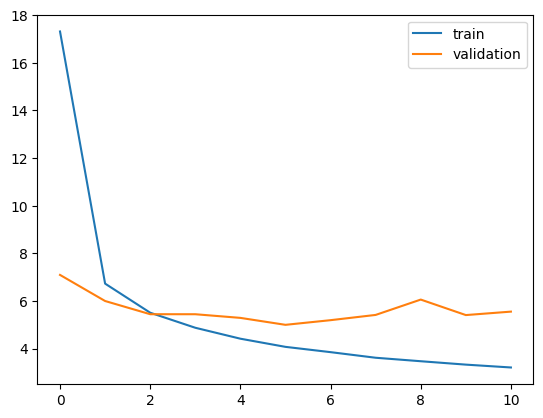

Repetition 2 model training started ...
Epoch 1/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 35.1238
Epoch 1: val_loss improved from inf to 4.60266, saving model to /content/drive/MyDrive/Solar_Project/Stanford-solar-forecasting-dataset/models/SUNSET_nowcast_2017_2019_data/repetition_2/best_model_repitition_2.h5


1229/1229 ━━━━━━━━━━━━━━━━━━━━ 132s 103ms/step - loss: 35.1091 - val_loss: 4.6027
Epoch 2/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 7.7974
Epoch 2: val_loss improved from 4.60266 to 3.61010, saving model to /content/drive/MyDrive/Solar_Project/Stanford-solar-forecasting-dataset/models/SUNSET_nowcast_2017_2019_data/repetition_2/best_model_repitition_2.h5


1229/1229 ━━━━━━━━━━━━━━━━━━━━ 116s 94ms/step - loss: 7.7970 - val_loss: 3.6101
Epoch 3/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 6.1732
Epoch 3: val_loss improved from 3.61010 to 3.34017, saving model to /content/drive/MyDrive/Solar_Project/Stanford-solar-forecasting-dataset/models/SUNSET_nowcast_2017_2019_data/repetition_2/best_model_repitition_2.h5


1229/1229 ━━━━━━━━━━━━━━━━━━━━ 116s 95ms/step - loss: 6.1730 - val_loss: 3.3402
Epoch 4/200
1228/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 5.2995
Epoch 4: val_loss improved from 3.34017 to 3.15681, saving model to /content/drive/MyDrive/Solar_Project/Stanford-solar-forecasting-dataset/models/SUNSET_nowcast_2017_2019_data/repetition_2/best_model_repitition_2.h5


1229/1229 ━━━━━━━━━━━━━━━━━━━━ 117s 95ms/step - loss: 5.2993 - val_loss: 3.1568
Epoch 5/200
1227/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 4.7913
Epoch 5: val_loss did not improve from 3.15681
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 113s 92ms/step - loss: 4.7911 - val_loss: 3.5925
Epoch 6/200
1228/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 4.4082
Epoch 6: val_loss did not improve from 3.15681
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 109s 88ms/step - loss: 4.4081 - val_loss: 3.2290
Epoch 7/200
1227/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 4.1034
Epoch 7: val_loss did not improve from 3.15681
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 110s 90ms/step - loss: 4.1033 - val_loss: 3.1681
Epoch 8/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 3.9259
Epoch 8: val_loss did not improve from 3.15681
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 108s 88ms/step - loss: 3.9258 - val_loss: 3.8300
Epoch 9/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 3.7029
Epoch 9: val_loss did not improve from 3.15681
1229/1229 

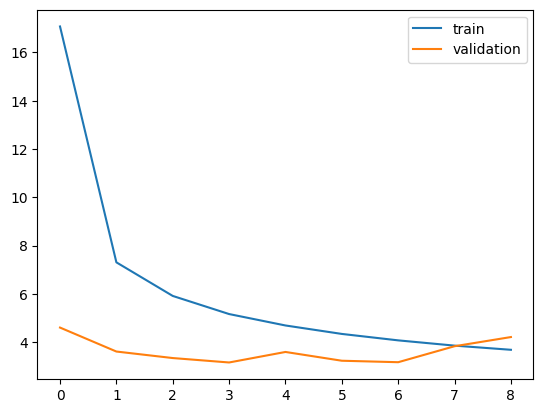

Repetition 3 model training started ...
Epoch 1/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 41.5247
Epoch 1: val_loss improved from inf to 6.97050, saving model to /content/drive/MyDrive/Solar_Project/Stanford-solar-forecasting-dataset/models/SUNSET_nowcast_2017_2019_data/repetition_3/best_model_repitition_3.h5


1229/1229 ━━━━━━━━━━━━━━━━━━━━ 132s 103ms/step - loss: 41.5063 - val_loss: 6.9705
Epoch 2/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 7.5544
Epoch 2: val_loss improved from 6.97050 to 5.08146, saving model to /content/drive/MyDrive/Solar_Project/Stanford-solar-forecasting-dataset/models/SUNSET_nowcast_2017_2019_data/repetition_3/best_model_repitition_3.h5


1229/1229 ━━━━━━━━━━━━━━━━━━━━ 117s 95ms/step - loss: 7.5540 - val_loss: 5.0815
Epoch 3/200
1228/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 5.9122
Epoch 3: val_loss improved from 5.08146 to 4.59372, saving model to /content/drive/MyDrive/Solar_Project/Stanford-solar-forecasting-dataset/models/SUNSET_nowcast_2017_2019_data/repetition_3/best_model_repitition_3.h5


1229/1229 ━━━━━━━━━━━━━━━━━━━━ 116s 94ms/step - loss: 5.9118 - val_loss: 4.5937
Epoch 4/200
1228/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 5.1604
Epoch 4: val_loss improved from 4.59372 to 4.45703, saving model to /content/drive/MyDrive/Solar_Project/Stanford-solar-forecasting-dataset/models/SUNSET_nowcast_2017_2019_data/repetition_3/best_model_repitition_3.h5


1229/1229 ━━━━━━━━━━━━━━━━━━━━ 116s 94ms/step - loss: 5.1602 - val_loss: 4.4570
Epoch 5/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 4.6652
Epoch 5: val_loss did not improve from 4.45703
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 115s 94ms/step - loss: 4.6651 - val_loss: 4.6422
Epoch 6/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 4.2813
Epoch 6: val_loss improved from 4.45703 to 4.10506, saving model to /content/drive/MyDrive/Solar_Project/Stanford-solar-forecasting-dataset/models/SUNSET_nowcast_2017_2019_data/repetition_3/best_model_repitition_3.h5


1229/1229 ━━━━━━━━━━━━━━━━━━━━ 112s 91ms/step - loss: 4.2813 - val_loss: 4.1051
Epoch 7/200
1227/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 4.0392
Epoch 7: val_loss did not improve from 4.10506
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 114s 93ms/step - loss: 4.0390 - val_loss: 4.6559
Epoch 8/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 3.7701
Epoch 8: val_loss did not improve from 4.10506
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 110s 90ms/step - loss: 3.7701 - val_loss: 4.2859
Epoch 9/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 3.6058
Epoch 9: val_loss did not improve from 4.10506
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 141s 115ms/step - loss: 3.6058 - val_loss: 5.1662
Epoch 10/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 3.4437
Epoch 10: val_loss did not improve from 4.10506
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 112s 91ms/step - loss: 3.4437 - val_loss: 4.4893
Epoch 11/200
1228/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 3.3481
Epoch 11: val_loss did not improve from 4.10506
1229/

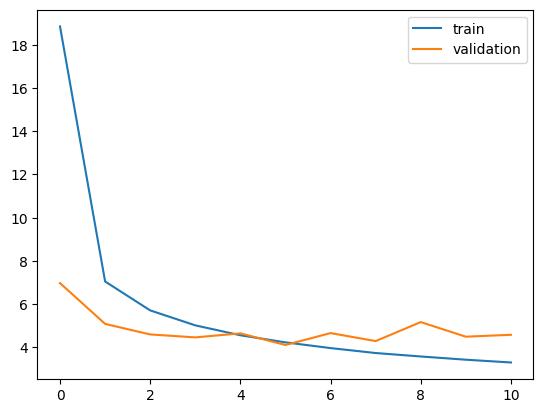

Repetition 4 model training started ...
Epoch 1/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 44.6137
Epoch 1: val_loss improved from inf to 6.12524, saving model to /content/drive/MyDrive/Solar_Project/Stanford-solar-forecasting-dataset/models/SUNSET_nowcast_2017_2019_data/repetition_4/best_model_repitition_4.h5


1229/1229 ━━━━━━━━━━━━━━━━━━━━ 132s 103ms/step - loss: 44.5934 - val_loss: 6.1252
Epoch 2/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 7.5364
Epoch 2: val_loss improved from 6.12524 to 5.03988, saving model to /content/drive/MyDrive/Solar_Project/Stanford-solar-forecasting-dataset/models/SUNSET_nowcast_2017_2019_data/repetition_4/best_model_repitition_4.h5


1229/1229 ━━━━━━━━━━━━━━━━━━━━ 116s 95ms/step - loss: 7.5360 - val_loss: 5.0399
Epoch 3/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 5.8702
Epoch 3: val_loss improved from 5.03988 to 4.63118, saving model to /content/drive/MyDrive/Solar_Project/Stanford-solar-forecasting-dataset/models/SUNSET_nowcast_2017_2019_data/repetition_4/best_model_repitition_4.h5


1229/1229 ━━━━━━━━━━━━━━━━━━━━ 115s 94ms/step - loss: 5.8700 - val_loss: 4.6312
Epoch 4/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 5.1262
Epoch 4: val_loss improved from 4.63118 to 4.41799, saving model to /content/drive/MyDrive/Solar_Project/Stanford-solar-forecasting-dataset/models/SUNSET_nowcast_2017_2019_data/repetition_4/best_model_repitition_4.h5


1229/1229 ━━━━━━━━━━━━━━━━━━━━ 116s 94ms/step - loss: 5.1261 - val_loss: 4.4180
Epoch 5/200
1227/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 4.5594
Epoch 5: val_loss did not improve from 4.41799
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 113s 92ms/step - loss: 4.5592 - val_loss: 4.5773
Epoch 6/200
1228/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 4.2011
Epoch 6: val_loss improved from 4.41799 to 4.24193, saving model to /content/drive/MyDrive/Solar_Project/Stanford-solar-forecasting-dataset/models/SUNSET_nowcast_2017_2019_data/repetition_4/best_model_repitition_4.h5


1229/1229 ━━━━━━━━━━━━━━━━━━━━ 113s 92ms/step - loss: 4.2010 - val_loss: 4.2419
Epoch 7/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 3.9129
Epoch 7: val_loss did not improve from 4.24193
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 112s 91ms/step - loss: 3.9129 - val_loss: 4.5686
Epoch 8/200
1228/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 3.6998
Epoch 8: val_loss did not improve from 4.24193
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 142s 116ms/step - loss: 3.6997 - val_loss: 4.4407
Epoch 9/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 3.5509
Epoch 9: val_loss did not improve from 4.24193
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 107s 87ms/step - loss: 3.5509 - val_loss: 4.9094
Epoch 10/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 3.3734
Epoch 10: val_loss did not improve from 4.24193
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 107s 87ms/step - loss: 3.3734 - val_loss: 4.5897
Epoch 11/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 3.2315
Epoch 11: val_loss did not improve from 4.24193
1229/

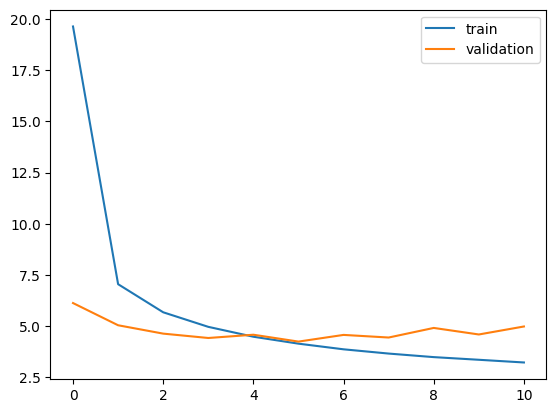

Repetition 5 model training started ...
Epoch 1/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 34.4543
Epoch 1: val_loss improved from inf to 4.95531, saving model to /content/drive/MyDrive/Solar_Project/Stanford-solar-forecasting-dataset/models/SUNSET_nowcast_2017_2019_data/repetition_5/best_model_repitition_5.h5


1229/1229 ━━━━━━━━━━━━━━━━━━━━ 134s 104ms/step - loss: 34.4402 - val_loss: 4.9553
Epoch 2/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 7.4369
Epoch 2: val_loss improved from 4.95531 to 4.01963, saving model to /content/drive/MyDrive/Solar_Project/Stanford-solar-forecasting-dataset/models/SUNSET_nowcast_2017_2019_data/repetition_5/best_model_repitition_5.h5


1229/1229 ━━━━━━━━━━━━━━━━━━━━ 116s 95ms/step - loss: 7.4366 - val_loss: 4.0196
Epoch 3/200
1228/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 5.9727
Epoch 3: val_loss improved from 4.01963 to 3.58284, saving model to /content/drive/MyDrive/Solar_Project/Stanford-solar-forecasting-dataset/models/SUNSET_nowcast_2017_2019_data/repetition_5/best_model_repitition_5.h5


1229/1229 ━━━━━━━━━━━━━━━━━━━━ 116s 94ms/step - loss: 5.9723 - val_loss: 3.5828
Epoch 4/200
1227/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 5.2052
Epoch 4: val_loss improved from 3.58284 to 3.42749, saving model to /content/drive/MyDrive/Solar_Project/Stanford-solar-forecasting-dataset/models/SUNSET_nowcast_2017_2019_data/repetition_5/best_model_repitition_5.h5


1229/1229 ━━━━━━━━━━━━━━━━━━━━ 115s 94ms/step - loss: 5.2049 - val_loss: 3.4275
Epoch 5/200
1228/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 4.6883
Epoch 5: val_loss did not improve from 3.42749
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 139s 113ms/step - loss: 4.6882 - val_loss: 3.9187
Epoch 6/200
1227/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 4.3300
Epoch 6: val_loss did not improve from 3.42749
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 142s 115ms/step - loss: 4.3299 - val_loss: 3.8262
Epoch 7/200
1228/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 4.0356
Epoch 7: val_loss did not improve from 3.42749
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 110s 89ms/step - loss: 4.0356 - val_loss: 3.7313
Epoch 8/200
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 3.8481
Epoch 8: val_loss did not improve from 3.42749
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 108s 88ms/step - loss: 3.8480 - val_loss: 3.9876
Epoch 9/200
1199/1229 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 3.6307

In [ ]:
# generate dayblock shuffled indices
indices_dayblock_shuffled = day_block_shuffle(times_trainval)

# initialize loss history list
train_loss_hist = []
val_loss_hist = []

for i in range(num_fold):

    # construct and compile model for each repetition to reinitialize the model weights
    keras.backend.clear_session()
    model = sunset_model()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate),loss='mse')

    # implementing 10-fold cross-validation
    print('Repetition {0} model training started ...'.format(i+1))

    # creating folder for saving model checkpoint
    save_directory = os.path.join(output_folder,'repetition_'+str(i+1))
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    # training and validation data preparation
    ## generate indices dataset for training and validation
    indices_train, indices_val = cv_split(indices_dayblock_shuffled,i,num_fold)
    ## load data from dataloader
    ds_train_batched = data_loader(data_path,indices_train)
    ds_val_batched = data_loader(data_path,indices_val,batch_size=500)

    # define callbacks for training
    ## early stopping rule: if the validation loss stop decreasing for 5 consecutive epoches
    earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    ## model check point: save model checkpoint for later use
    checkpoint = keras.callbacks.ModelCheckpoint(os.path.join(save_directory,'best_model_repitition_'+str(i+1)+'.h5'),
                                monitor='val_loss', mode='min', save_best_only=True, verbose=1)

    # training the model and record training and validation loss
    history = model.fit(ds_train_batched, epochs=num_epochs, steps_per_epoch=len(indices_train)//batch_size+1,
                               verbose=1, callbacks=[earlystop,checkpoint], validation_data=ds_val_batched,
                              validation_steps=len(indices_val)//batch_size+1)
    train_loss_hist.append(history.history['loss'])
    val_loss_hist.append(history.history['val_loss'])

    # saving model training and validation loss history
    # 리스트를 강제로 object 타입의 numpy 배열로 변환해서 저장
    np.save(os.path.join(output_folder,'train_loss_hist.npy'), np.array(train_loss_hist, dtype=object))
    np.save(os.path.join(output_folder,'val_loss_hist.npy'), np.array(val_loss_hist, dtype=object))

    # plot training and validation history
    plt.plot(train_loss_hist[i],label='train')
    plt.plot(val_loss_hist[i],label='validation')
    plt.legend()
    plt.show()

In [ ]:
# summary of training and validation results
best_train_loss_MSE = np.zeros(num_fold)
best_val_loss_MSE = np.zeros(num_fold)

for i in range(num_fold):
    best_val_loss_MSE[i] = np.min(val_loss_hist[i])
    idx = np.argmin(val_loss_hist[i])
    best_train_loss_MSE[i] = train_loss_hist[i][idx]
    print('Model {0}  -- train loss: {1:.2f}, validation loss: {2:.2f} (RMSE)'.format(i+1, np.sqrt(best_train_loss_MSE[i]), np.sqrt(best_val_loss_MSE[i])))
print('The mean train loss (RMSE) for all models is {0:.2f}'.format(np.mean(np.sqrt(best_train_loss_MSE))))
print('The mean validation loss (RMSE) for all models is {0:.2f}'.format(np.mean(np.sqrt(best_val_loss_MSE))))

### Model testing

In [ ]:
# load testing data
times_test = np.load(os.path.join(data_folder,"times_test.npy"),allow_pickle=True)
print("times_test.shape:", times_test.shape)

with h5py.File(data_path,'r') as f:

    # read in the data
    images_log_test = f['test']['images_log'][...]
    pv_log_test = f['test']['pv_log'][...]

# process image data
images_log_test = (images_log_test/255.0).astype('float32')
pv_log_test = pv_log_test.astype('float32')

print("images_log_test.shape:",images_log_test.shape)
print("pv_log_test.shape:",pv_log_test.shape)

times_test.shape: (14003,)
images_log_test.shape: (14003, 64, 64, 3)
pv_log_test.shape: (14003,)


In [ ]:
# evaluate model on the test set and generate predictions
'''
loss = np.zeros((num_fold,len(times_test)))
prediction = np.zeros((num_fold,len(times_test)))
'''
loss = np.zeros((1,len(times_test)))
prediction = np.zeros((1,len(times_test)))

''' 모델학습 중간에 끊겨서 1번 모델만 사용
for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path , compile=False)
    model.compile(optimizer='adam', loss='mse')

    # model evaluation
    print("evaluating performance for the model".format(i+1))
    loss[i] = model.evaluate(x=images_log_test, y=pv_log_test, batch_size=200, verbose=1)

    # generate prediction
    print("generating predictions for the model".format(i+1))
    prediction[i] = np.squeeze(model.predict(images_log_test, batch_size=200, verbose=1))
'''
print("loading repetition {0} model ...".format(1))
model_path = os.path.join(output_folder,'repetition_'+str(1),'best_model_repitition_'+str(1)+'.h5')
model = keras.models.load_model(model_path , compile=False)
model.compile(optimizer='adam', loss='mse')
print("evaluating performance for the model".format(1))
loss[0] = model.evaluate(x=images_log_test, y=pv_log_test, batch_size=200, verbose=1)
print("generating predictions for the model".format(1))
prediction[0] = np.squeeze(model.predict(images_log_test, batch_size=200, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions.npy'),prediction)

# using the ensemble mean of the 10 models as the final prediction
print('-'*50)
print("model ensembling ...")
prediction_ensemble = np.mean(prediction,axis=0)
loss_ensemble = np.sqrt(np.mean((prediction_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} for the ensemble model".format(loss_ensemble))

loading repetition 1 model ...
evaluating performance for the model
71/71 ━━━━━━━━━━━━━━━━━━━━ 33s 453ms/step - loss: 2.8746
generating predictions for the model
71/71 ━━━━━━━━━━━━━━━━━━━━ 33s 463ms/step
--------------------------------------------------
model ensembling ...
the test set RMSE is 2.481 for the ensemble model


In [ ]:
# formulate sunny and cloudy test days
sunny_dates = [(2017,9,15),(2017,10,6),(2017,10,22),
               (2018,2,16),(2018,6,12),(2018,6,23),
               (2019,1,25),(2019,6,23),(2019,7,14),(2019,10,14)]
cloudy_dates = [(2017,6,24),(2017,9,20),(2017,10,11),
                (2018,1,25),(2018,3,9),(2018,10,4),
                (2019,5,27),(2019,6,28),(2019,8,10),(2019,10,19)]

sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

## generate mask for the sunny days
mask = np.zeros(len(pv_log_test),dtype=bool)
for i in sunny_dates_test:
    mask[np.where(dates_test==i)[0]]=1

## apply the mask to the dataset
times_test_sunny = times_test[mask]
pv_log_test_sunny = pv_log_test[mask]
images_log_test_sunny = images_log_test[mask]
prediction_ensemble_sunny = prediction_ensemble[mask]
print("times_test_sunny.shape:",times_test_sunny.shape)

times_test_cloudy = times_test[~mask]
pv_log_test_cloudy = pv_log_test[~mask]
images_log_test_cloudy = images_log_test[~mask]
prediction_ensemble_cloudy = prediction_ensemble[~mask]
print("times_test_cloudy.shape:",times_test_cloudy.shape)

times_test_sunny.shape: (6986,)
times_test_cloudy.shape: (7017,)


In [ ]:
# RMSE for sunny and cloudy days individually
rmse_sunny = np.sqrt(np.mean(np.square((prediction_ensemble_sunny-pv_log_test_sunny))))
rmse_cloudy = np.sqrt(np.mean(np.square((prediction_ensemble_cloudy-pv_log_test_cloudy))))
rmse_overall = np.sqrt((rmse_sunny**2*len(pv_log_test_sunny)+rmse_cloudy**2*len(pv_log_test_cloudy))/(len(pv_log_test)))

print("test set sunny days RMSE: {0:.3f}".format(rmse_sunny))
print("test set cloudy days RMSE: {0:.3f}".format(rmse_cloudy))
print("test set overall RMSE: {0:.3f}".format(rmse_overall))

test set sunny days RMSE: 0.800
test set cloudy days RMSE: 3.412
test set overall RMSE: 2.481


In [ ]:
# MAE for sunny and cloudy days individually
mae_sunny = np.mean(np.abs((prediction_ensemble_sunny-pv_log_test_sunny)))
mae_cloudy = np.mean(np.abs((prediction_ensemble_cloudy-pv_log_test_cloudy)))
mae_overall = (mae_cloudy*len(pv_log_test_cloudy) + mae_sunny*len(pv_log_test_sunny))/(len(pv_log_test))

print("test set sunny days MAE: {0:.3f}".format(mae_sunny))
print("test set cloudy days MAE: {0:.3f}".format(mae_cloudy))
print("test set overall MAE: {0:.3f}".format(mae_overall))

test set sunny days MAE: 0.657
test set cloudy days MAE: 2.438
test set overall MAE: 1.549


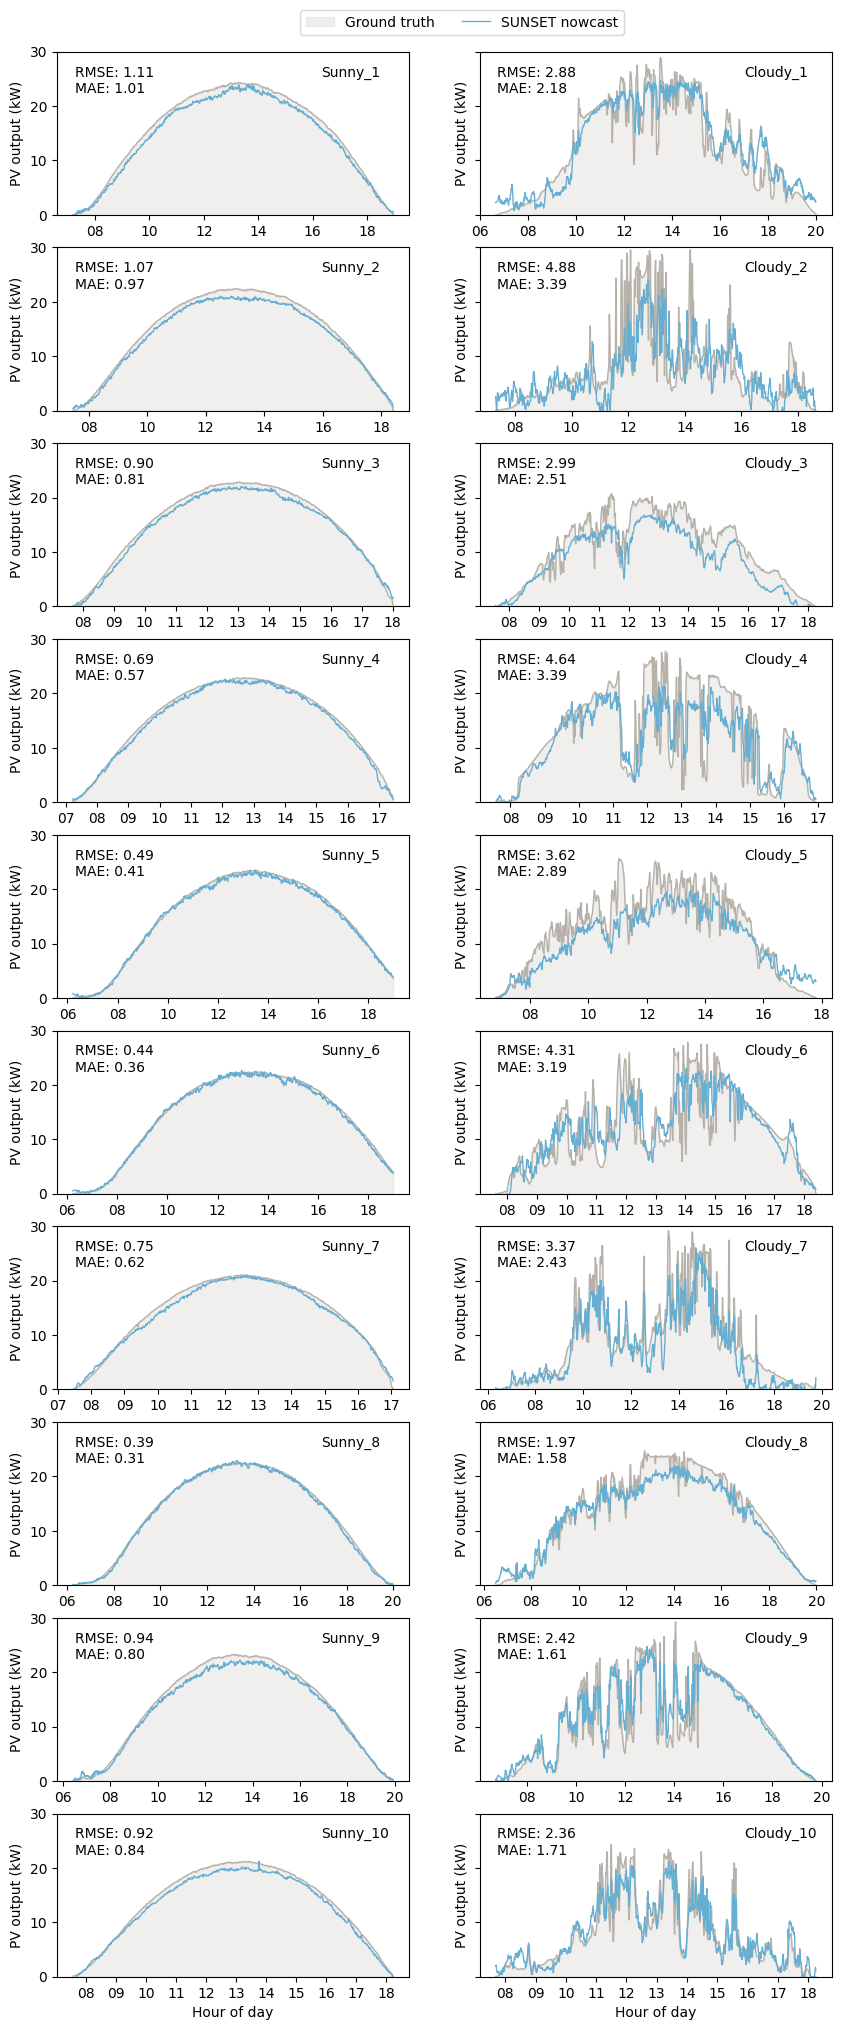

In [ ]:
# visualization of nowcast predictions
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(10,2,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

blue = '#67AFD2'
grey =  '#B6B1A9'

for i,date in enumerate(sunny_dates_test):
    ax = axarr[i,0]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=grey)
    ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1,label = 'SUNSET nowcast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.75,0.85,'Sunny_'+str(i+1), transform=ax.transAxes)
    ax.text(0.05,0.75,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i,1]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=grey)
    ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1,label = 'SUNSET nowcast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.75,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)
    ax.text(0.05,0.75,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)


axarr[0,0].set_ylim(0, 30)
axarr[0,0].legend(bbox_to_anchor= [1.15,1.3], loc = 'upper center', ncol = 3)
axarr[-1,0].set_xlabel('Hour of day')
axarr[-1,1].set_xlabel('Hour of day')

f.set_size_inches(10,25)
plt.show()